In [ ]:
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras import layers
import tensorflow_addons as tfa

import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
AUTO = tf.data.AUTOTUNE
batch_size = 128
epochs = 5
img_size = 32 #cropping size
rnd = 26 #random seed

projection_dim = 4096
latent_dim = 256
weight_decay = 1e-6



In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

print("Number of training samples: ", len(x_train))
print("Number of test samples: ", len(x_test))

Number of training samples:  50000
Number of test samples:  10000


In [ ]:
print(x_train[1].shape)

(32, 32, 3)


In [ ]:
""" Data augmentation """
### Note that the augmentation pipelines implemented here are: (1) resizing and cropping, 
### and (2) color correction/distortion. These are the bare minimum augmentation methods used in different SSL methods 

def flip_random_crop(image):
    # With random crops we also apply horizontal flipping.
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_crop(image, (img_size, img_size, 3))
    return image


def color_change(x, strength=[0.4, 0.4, 0.4, 0.1]):
    x = tf.image.random_brightness(x, max_delta=0.8 * strength[0])
    x = tf.image.random_contrast(
        x, lower=1 - 0.8 * strength[1], upper=1 + 0.8 * strength[1]
    )
    x = tf.image.random_saturation(
        x, lower=1 - 0.8 * strength[2], upper=1 + 0.8 * strength[2]
    )
    x = tf.image.random_hue(x, max_delta=0.2 * strength[3])
    x = tf.clip_by_value(x, 0, 255)
    return x

def color_convert(x):
  x = tf.image.rgb_to_grayscale(x)
  x = tf.tile(x, [1, 1, 3])
  return x

def random_apply(func, x, p):
    if tf.random.uniform([], minval=0, maxval=1) < p:
        return func(x)
    else:
        return x

def custom_augment(image):
  #plt.imshow(image)
  #plt.title('image pre-transform')
  
  image = flip_random_crop(image)
  #plt.imshow(image)
  #plt.title('image post crop')
  
  image = random_apply(color_change, image, p=0.8)
  #plt.imshow(image)
  #plt.title('image post color change')

  image = random_apply(color_convert, image, p=0.2)
  #plt.imshow(image)
  #plt.title('image post conversion to grayscale') 
  return image


Convert data to Tf.dataset 


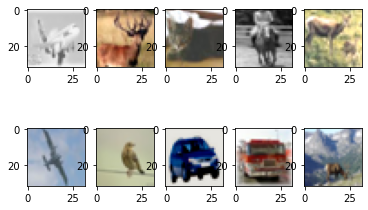

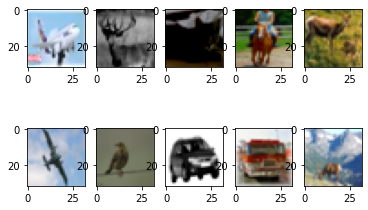

In [ ]:
ssl_ver_1 = tf.data.Dataset.from_tensor_slices(x_train)
ssl_ver_1 = (
    ssl_ver_1.shuffle(1024, seed=rnd)
    .map(custom_augment, num_parallel_calls=AUTO)
    .batch(batch_size)
    .prefetch(AUTO)
)

ssl_ver_2 = tf.data.Dataset.from_tensor_slices(x_train)
ssl_ver_2 = (
    ssl_ver_2.shuffle(1024, seed=rnd)
    .map(custom_augment, num_parallel_calls=AUTO)
    .batch(batch_size)
    .prefetch(AUTO)
)

ssl_all_ver = tf.data.Dataset.zip((ssl_ver_1, ssl_ver_2))

# view augmented images
example_img_ver_1 = next(iter(ssl_ver_1))

for n in range(10):
  
  ax = plt.subplot(2, 5, n + 1)
  plt.imshow(example_img_ver_1[n].numpy().astype("int"))
 # plt.title("example images: augmentation version 1")
plt.show()

example_img_ver_2 = next(iter(ssl_ver_2))
for n in range(10):
  ax = plt.subplot(2, 5, n + 1)
  plt.imshow(example_img_ver_2[n].numpy().astype("int"))
 # plt.title("example images: augmentation version 2")
plt.show()

Define architecture

In [ ]:
!wget -q https://git.io/JYx2x -O resnet_cifar10_v2.py

In [ ]:
import resnet_cifar10_v2

n = 2
d = n*9 + 2
num_blocks = ((d - 2) // 9) - 1

def get_encoder():
  
  #define input

  inputs = layers.Input((img_size, img_size, 3))
  x = layers.experimental.preprocessing.Rescaling(scale=1.0 / 127.5, offset=-1)(inputs)
  x = resnet_cifar10_v2.stem(x)
  x = resnet_cifar10_v2.learner(x, num_blocks)
  x = layers.GlobalAveragePooling2D(name="backbone_pool")(x)
  
  # projection

  x = layers.Dense(projection_dim, use_bias=False, kernel_regularizer=regularizers.l2(weight_decay))(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)
  x = layers.Dense(projection_dim, use_bias=False, kernel_regularizer=regularizers.l2(weight_decay))(x)
  outputs = layers.BatchNormalization()(x)
  return tf.keras.Model(inputs, outputs, name="encoder")

In [ ]:
def get_predictor():
  model = tf.keras.Sequential(
     [
      layers.Input((projection_dim,)),
      layers.Dense(
          latent_dim,
          use_bias=False,
          kernel_regularizer=regularizers.l2(weight_decay),
      ),
      layers.ReLU(),
      layers.BatchNormalization(),
      layers.Dense(projection_dim),
     ],
     name = "predictor", 
  )
  return model

In [ ]:
## Pre-training Loop
# Regression loss between output of prediction 'p' and stop gradient 'z'
def compute_loss(p, z):
  z = tf.stop_gradient(z)
  p = tf.math.l2_normalize(p, axis=-1) #in simsiam, axis=1
  z = tf.math.l2_normalize(z, axis=-1) #in simsiam, axis=1
  return -tf.reduce_mean(tf.reduce_sum((p * z), axis=-1))#in simsiam, axis=1

In [ ]:
class SimSiam(tf.keras.Model):
  def __init__(self, encoder, predictor):
    super(SimSiam, self).__init__()
    self.encoder = encoder
    self.predictor = predictor
    self.loss_tracker = tf.keras.metrics.Mean(name="loss")

  @property
  def metrics(self):
    return [self.loss_tracker]

  def train_step(self, data):
    # Unpack the data
    data_one, data_two = data

    # Forward pass
    with tf.GradientTape() as tape:
      z1, z2 = self.encoder(data_one), self.encoder(data_two)
      p1, p2 = self.predictor(z1), self.predictor(z2)
      loss = compute_loss(p1, z2) / 2 + compute_loss(p2, z1) /2

    learnable_params = (
        self.encoder.trainable_variables + self.predictor.trainable_variables
    )
    gradients = tape.gradient(loss, learnable_params)
    self.optimizer.apply_gradients(zip(gradients, learnable_params))

    # Monitor loss
    self.loss_tracker.update_state(loss)
    return {"loss": self.loss_tracker.result()}



In [ ]:
#define learning scheduler -- cosine

num_train_samples = len(x_train)
steps = epochs * (num_train_samples // batch_size)
lr_decayed_fn = tf.keras.experimental.CosineDecay(
    initial_learning_rate=0.45, decay_steps=steps 
)

# early-stopping criteria

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="loss", patience=5, restore_best_weights=True
)

# compile

simsiam = SimSiam(get_encoder(), get_predictor())
simsiam.compile(optimizer=tf.keras.optimizers.(lr_decayed_fn, momentum=0.9, eta = 0.001))
history = simsiam.fit(ssl_all_ver, epochs=epochs, callbacks=[early_stopping])






Epoch 1/5
391/391 [==============================] - 102s 253ms/step - loss: -0.8825
Epoch 2/5
391/391 [==============================] - 99s 254ms/step - loss: -0.9168
Epoch 3/5
391/391 [==============================] - 100s 255ms/step - loss: -0.9291
Epoch 4/5
391/391 [==============================] - 100s 254ms/step - loss: -0.9343
Epoch 5/5
391/391 [==============================] - 100s 254ms/step - loss: -0.9360


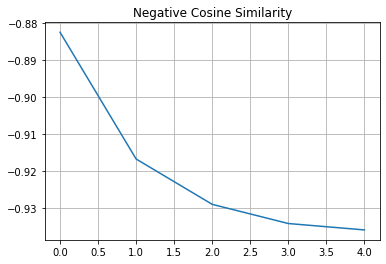

In [ ]:
# visualizing
plt.plot(history.history['loss'])
plt.grid()
plt.title("Negative Cosine Similarity")
plt.show()


In [ ]:
# We first create labeled `Dataset` objects.
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# Then we shuffle, batch, and prefetch this dataset for performance. We
# also apply random resized crops as an augmentation but only to the
# training set.
train_ds = (
    train_ds.shuffle(1024)
    .map(lambda x, y: (flip_random_crop(x), y), num_parallel_calls=AUTO)
    .batch(batch_size)
    .prefetch(AUTO)
)
test_ds = test_ds.batch(batch_size).prefetch(AUTO)

# Extract the backbone ResNet20.
backbone = tf.keras.Model(
    simsiam.encoder.input, simsiam.encoder.get_layer("backbone_pool").output
)

# We then create our linear classifier and train it.
backbone.trainable = False
inputs = layers.Input((img_size, img_size, 3))
x = backbone(inputs, training=False)
outputs = layers.Dense(10, activation="softmax")(x)
linear_model = tf.keras.Model(inputs, outputs, name="linear_model")

# Compile model and start training.
linear_model.compile(
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
    optimizer=tf.keras.optimizers.SGD(lr_decayed_fn, momentum=0.9),
)
history = linear_model.fit(
    train_ds, validation_data=test_ds, epochs=epochs, callbacks=[early_stopping]
)
_, test_acc = linear_model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

Epoch 1/5
391/391 [==============================] - 20s 45ms/step - loss: 3.7954 - accuracy: 0.1519 - val_loss: 3.7175 - val_accuracy: 0.2137
Epoch 2/5
391/391 [==============================] - 16s 42ms/step - loss: 3.7034 - accuracy: 0.2139 - val_loss: 3.6745 - val_accuracy: 0.2290
Epoch 3/5
391/391 [==============================] - 16s 42ms/step - loss: 3.6679 - accuracy: 0.2243 - val_loss: 3.6565 - val_accuracy: 0.2339
Epoch 4/5
391/391 [==============================] - 17s 42ms/step - loss: 3.6526 - accuracy: 0.2317 - val_loss: 3.6501 - val_accuracy: 0.2333
Epoch 5/5
79/79 [==============================] - 3s 35ms/step - loss: 3.6491 - accuracy: 0.2309
Test accuracy: 23.09%
